# Import Dependencies

In [83]:
import torch
from torch.types import Tensor

import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam, SGD, Adadelta, RMSprop

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.optimize import minimize
# from pymoo.problems import get_problem
from pymoo.core.problem import Problem

from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

from pymoo.core.problem import Problem
from pymoo.core.result import Result

from pymoo.optimize import minimize

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.patches as patches
import seaborn as sns
style.use("ggplot")


# Make Data & Environmet & Practical Function

In [84]:
def generate_structured_environment(size_cm, num_blocks=5, block_size_range=(5, 20), seed=None):
    """
    size_cm: tuple[int] مثل (100, 100)
    dimension: 2 یا 3
    num_blocks: تعداد ساختارهای مانعی (مثل دیوار یا ستون)
    block_size_range: حداقل و حداکثر اندازه‌ی هر مانع (به سانتی‌متر)
    seed: مقدار تصادفی ثابت برای reproducibility
    
    خروجی: تنسور محیط با 0 و 1
    """
    # import torch
    # import numpy as np
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    dimension = len(size_cm)
    if dimension == 2:
        H, W = size_cm
        env = torch.zeros((H, W), dtype=torch.float32)
    elif dimension == 3:
        H, W, D = size_cm
        env = torch.zeros((H, W, D), dtype=torch.float32)
    else:
        raise ValueError("Only 2D or 3D is supported.")

    for _ in range(num_blocks):
        if dimension == 2:
            h = np.random.randint(block_size_range[0], block_size_range[1])
            w = np.random.randint(block_size_range[0], block_size_range[1])
            x = np.random.randint(0, H - h)
            y = np.random.randint(0, W - w)
            env[x:x+h, y:y+w] = 1.0  # مانع مستطیلی
        else:
            h = np.random.randint(block_size_range[0], block_size_range[1])
            w = np.random.randint(block_size_range[0], block_size_range[1])
            d = np.random.randint(block_size_range[0], block_size_range[1])
            x = np.random.randint(0, H - h)
            y = np.random.randint(0, W - w)
            z = np.random.randint(0, D - d)
            env[x:x+h, y:y+w, z:z+d] = 1.0  # مانع مکعبی

    return env


def nodes_pose(num_pop : int, num_node : int = 5, dimension : int = 2):
    X = torch.rand(num_pop, num_node, dimension, requires_grad=True)
    return X

def denormalize_positions(X_norm: torch.Tensor, size_cm : tuple[int,int] | torch.Size ) -> torch.Tensor:
    """
    X_norm: تنسور با مقادیر نرمالیزه شده بین 0 و 1  
    size_cm: اندازه‌ی محیط به سانتی‌متر (مثلا (100, 100) یا (100, 100, 100))
    """
    if len(size_cm) == 2:
        size_tensor = torch.tensor(size_cm, dtype=X_norm.dtype, device=X_norm.device)
    elif len(size_cm) == 3:
        # برای 3 بعدی، اندازه باید به صورت (H, W, D) باشد
        if len(size_cm) != 3:
            raise ValueError("For 3D input, size_cm must be a tuple of length 3.")
        # تبدیل به تنسور با نوع و دستگاه مشابه X_norm
    size_tensor = torch.tensor(size_cm, dtype= X_norm.dtype , device=X_norm.device)
    return (X_norm * size_tensor).float()  # این هنوز leaf نیست ولی گراف وصله


def positioning_nodes(env : torch.Tensor , nodes_pose : torch.Tensor , defines_as : int = 2):
    env_prime = env.clone()
    nodes_pose = nodes_pose.long()
    for pos in nodes_pose:
        if defines_as == 3 and env_prime[pos[0], pos[1]] == 1:
            print(f"Position {pos} is already occupied in the environment.", )
        else:
            env_prime[pos[0], pos[1]] = defines_as
    return env_prime


def find_best(X : torch.Tensor, 
              fn : nn.Module,
              verbose : bool = True) -> torch.Tensor:
    best_answer = torch.argmin(
    torch.tensor([fn(X[i])
      for i in range(X.shape[0])]))
    if verbose:
        print(f"Best Answer is in index: {best_answer}")
    
    return X[best_answer]



# Visulizer Functions

In [85]:
def plot_2d_environment(env_tensor: torch.Tensor, radii: torch.Tensor | None = None):
    """
    env_tensor: ماتریس 2D که مقادیر:
        0: فضای آزاد
        1: مانع
        2: سنسور
        3: علامت ستاره

    radii: تنسور 1D به طول تعداد سنسورها (2ها)، شامل شعاع‌های دایره‌ی توخالی دور هر سنسور
    """

    H, W = env_tensor.shape
    plt.figure(figsize=(6, 6))
    plt.imshow((env_tensor == 1).numpy(), cmap='Greys', origin='upper')  # فقط موانع

    ax = plt.gca()
    sensor_indices = []

    for y in range(H):
        for x in range(W):
            val = env_tensor[y, x].item()
            if val == 2:
                plt.plot(x, y, 'ro', markersize=8, label='Sensor' if not sensor_indices else "")
                sensor_indices.append((x, y))
            elif val == 3:
                plt.plot(x, y, 'b*', markersize=12, label='Star')

    # اضافه‌کردن دایره‌های توخالی بر اساس شعاع‌ها
    if radii is not None:
        assert len(radii) == len(sensor_indices), "طول radii باید با تعداد سنسورها (2ها) برابر باشد."
        for (x, y), radius in zip(sensor_indices, radii):
            circle = patches.Circle((x, y), radius.item(), fill=False, edgecolor='r', linestyle='--', linewidth=1.5)
            ax.add_patch(circle)

    # تنظیمات نهایی
    plt.title("2D Environment")
    plt.xlabel("X axis (cm)")
    plt.ylabel("Y axis (cm)")
    plt.xlim(-0.5, W - 0.5)
    plt.ylim(H - 0.5, -0.5)
    plt.grid(False)

    handles, labels = plt.gca().get_legend_handles_labels()
    # if handles:
    #     plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


def plot_3d_environment_slices(env_tensor, axis=2):
    """
    env_tensor: تنسور 3بعدی PyTorch
    axis: محور ثابت نگه‌داشته شده برای slice (مثل Z ثابت = تصاویر XY)
    """
    import matplotlib.pyplot as plt

    slices = env_tensor.shape[axis]
    fig, axs = plt.subplots(1, min(slices, 5), figsize=(15, 3))

    for i in range(min(slices, 5)):
        if axis == 0:
            img = env_tensor[i, :, :]
        elif axis == 1:
            img = env_tensor[:, i, :]
        else:
            img = env_tensor[:, :, i]
        axs[i].imshow(img.numpy(), cmap='Greys', origin='lower')
        axs[i].set_title(f"Slice {i}")
        axs[i].axis('off')

    plt.suptitle("Slices of 3D Environment")
    plt.show()

# define Everything

In [86]:
ENV_SIZE : tuple[int,int] = (100, 100)
NUM_BLOCKS : int = 2
BLOCK_SIZE : tuple[int, int ] = (10,20)

pop_size = 100
Dimension = 2 
Learning_rate = .23

X : int = 10
K : int = 5

n_simu = 10
chance_in_net_favor = .50
n_epoch = 1

Radius = 11

idw = intra_distance_weight = 1

obstacle_weight = idw * 1 
target_distance_weight = idw * .21

# obstacle_weight , intra_distance_weight , target_distance_weight = torch.rand(3) 

print(f"obstacle_weight: {obstacle_weight}\nintra_distance_weight: {intra_distance_weight}\ntarget_distance_weight: {target_distance_weight}")


radii = torch.ones(size= (X,)) * 10 #torch.randint(low=5, high=10, size=(X,))
SEED = None


first_env = generate_structured_environment(size_cm = ENV_SIZE,
                                            num_blocks = NUM_BLOCKS ,
                                            block_size_range= BLOCK_SIZE,
                                            seed=SEED)

Sensor_Nodes = nodes_pose(num_pop= pop_size, num_node = X)
Target_Points = nodes_pose(num_pop= pop_size, num_node = K)

new_X = denormalize_positions(Sensor_Nodes[0], ENV_SIZE)
new_target_point = denormalize_positions(Target_Points[0], ENV_SIZE)
# new_X.retain_grad()

first_env = positioning_nodes(first_env, new_target_point, 3)
# Visualize initial environment
new_env = positioning_nodes(first_env, new_X)


obstacle_weight: 1
intra_distance_weight: 1
target_distance_weight: 0.21
Position tensor([49, 78]) is already occupied in the environment.


# Display one of many

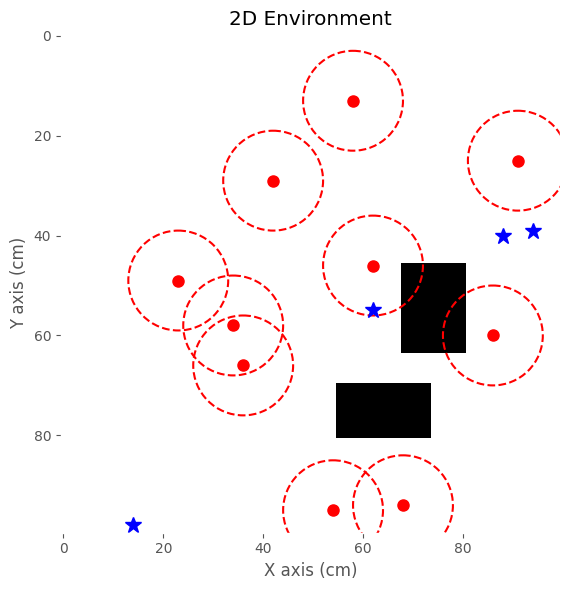

In [87]:
plot_2d_environment(new_env, radii=radii)


# Define Fitness(Loss) Function

$$ 
fitness(X) = \sum_{X}  || x_i - x_j ||_2 + \sum_{T} || x_i - t_i ||_2 - \lambda      \text{||E||} \\

x : \text{sensors positions} \\
t : \text{targer point positions} \\
E : \text{environmet obsticle}
$$

In [ ]:
def masked_centered_convolution_sum(x: torch.Tensor, kernel_size: int = 3) -> torch.Tensor:
    """
    Compute convolution sum centered on sensor positions, ignoring obstacles.
    
    Args:
        x (torch.Tensor): 2D environment tensor (2: sensor, 1: obstacle, 0: free).
        kernel_size (int): Size of the convolution kernel.
    
    Returns:
        torch.Tensor: Sum of convolution values at sensor positions.
    """
    # assert x.dim() == 2
    P , H, W = x.shape
    pad = kernel_size // 2

    kernel = torch.ones((kernel_size, kernel_size), dtype=x.dtype, device=x.device, requires_grad=True)
    total = torch.tensor(0.0, dtype=x.dtype, device=x.device, requires_grad=True)

    for p in range(P):
        # Iterate over each sensor position in the batch
        for i in range(pad, H - pad):
            for j in range(pad, W - pad):
                if x[p, i, j].item() == 2:
                    patch = x[p, i-pad:i+pad+1, j-pad:j+pad+1]
                    obstacle_mask = (patch != 1).float()
                    masked_patch = patch * obstacle_mask
                    total = total + (masked_patch * kernel).sum()
    # for i in range(pad, H - pad):
    #     for j in range(pad, W - pad):
    #         if x[i, j].item() == 2:
    #             patch = x[i-pad:i+pad+1, j-pad:j+pad+1]
    #             obstacle_mask = (patch != 1).float()
    #             masked_patch = patch * obstacle_mask
    #             total = total + (masked_patch * kernel).sum()

    return total

class FitnessLoss(nn.Module):
    def __init__(self,
                 first_env : Tensor, 
                 radius : int = 3, 
                 target_point: Tensor | None = None, 
                 obstacle_weight : float =1.0, 
                 intra_distance_weight : float = 1.0, 
                 target_distance_weight : float = 1.0
                )-> None:
        """
        radius: شعاع کانولوشن
        target_point: نقطه هدف (1, d)
        obstacle_weight: ضریب جریمه نزدیک شدن به موانع
        intra_distance_weight: ضریب فاصله بین سنسورها
        target_distance_weight: ضریب فاصله از هدف
        """
        super().__init__()
        self.radius = radius
        self.target_point = target_point.detach().clone() if target_point is not None else None
        self.obstacle_weight = obstacle_weight
        self.intra_distance_weight = intra_distance_weight
        self.target_distance_weight = target_distance_weight
        self.first_env = first_env

    def forward(self, 
                X: torch.Tensor, 
                ) -> torch.Tensor:
        """
        Compute fitness loss for sensor positions.
        
        Args:
            X (torch.Tensor): Sensor positions, shape (num_sensors, dimension).
            env (torch.Tensor): 2D environment tensor.
        
        Returns:
            torch.Tensor: Total loss (to be minimized).
        """
        # فاصله بین سنسورها
        dists_intra = torch.cdist(X, X, p=2)
        # intra_sum = F.normalize(dists_intra).sum()
        intra_sum = dists_intra.sum() #/ (X.shape[0] * (X.shape[0] - 1) + 1e-6)  # Normalize

        # فاصله تا هدف
        if self.target_point is not None:
            dists_target = torch.cdist(X, self.target_point, p=2)
            # target_sum = F.normalize(dists_target).sum()
            target_sum = dists_target.sum() #/ (X.shape[0] * self.target_point.shape[0] + 1e-6)  # Normalize

        # کانولوشن موانع
        kernel_size = 2 * self.radius + 1
        kernel = torch.ones((1, 1, kernel_size, kernel_size), # [out_ch, in_ch, kH, kW]
                             dtype=X.dtype, device=X.device, 
                             requires_grad=False)

        # [batch, channels, height, width] 
        # for input and [out_channels, in_channels, kH, kW] for kernel.
        # کانولوشن برای محاسبه جریمه موانع
        conv = nn.Conv2d(in_channels=1, 
                        out_channels=1,
                        bias=False,
                        kernel_size=self.radius,
                        padding='same', 
                        groups=1)
        conv.weight = nn.Parameter(kernel)  
        env_input = self.first_env.unsqueeze(0).unsqueeze(0)  # shape = [1, 1, 100, 100]
        # obstacle_penalty = F.normalize(conv(env_input)).mean()  
        obstacle_penalty = masked_centered_convolution_sum(env_input.squeeze(0), kernel_size)

        loss = (
            self.intra_distance_weight * intra_sum +
            self.target_distance_weight * target_sum -
            self.obstacle_weight * obstacle_penalty
        )

        return loss


# Traditional Evolutionary Method

In [138]:
class DCPMK(Problem):
    def __init__(self, 
                 pop: torch.Tensor, 
                 env: torch.Tensor,
                 target_point: torch.Tensor | None, 
                 fitness_fn: nn.Module,
                 )-> None:

        self.pop_size, self.n_sensors, self.ndim = pop.shape
        super().__init__(
            n_var =  self.n_sensors * self.ndim,
            n_obj=1,
            n_ieq_constr=0,
            xl=0.0,
            xu=1.0
        )

        self.env = env.detach().clone()
        # self.pos = pop.detach().clone()
        self.target_point = target_point.detach().clone() # type: ignore

        self.fitness_fn = fitness_fn

    def _evaluate(self, X, out, *args, **kwargs):
        X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=False)
        # Reshape to (pop_size, n_sensors, ndim)
        X_tensor = X_tensor.reshape(self.pop_size, self.n_sensors, self.ndim)

        losses = []
        for i in range(X_tensor.shape[0]):
            # Denormalize positions to environment size
            # X_denorm = denormalize_positions(X_tensor[i], self.env.shape)
            loss : Tensor = self.fitness_fn(X_tensor[i])
            losses.append(loss.item())

        out["F"] = torch.tensor(losses).reshape(-1, 1)

# make network

In [139]:
class NetWorkAdapter(nn.Module):
    def __init__(self,num_pop: int, input_size : int  , *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        # self.input : int = input
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=64),
            nn.Sigmoid(),
            # nn.Linear(in_features=16, out_features=32),
            # nn.Sigmoid(),
            # nn.Linear(in_features=32, out_features=16),
            # nn.Sigmoid()
            
        )
        # self.h0 = torch.randn(num_pop,24,  32)
        # self.c0 = torch.randn(num_pop, 24, 32)

        self.lstm = nn.LSTM(input_size=64, 
                            hidden_size= 32, 
                            num_layers=12, 
                            bidirectional=True)
        self.fc2 = nn.Sequential(
                    nn.Linear(in_features=64, out_features=input_size),
                    nn.Sigmoid()
                            )
        pass

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        rnn, (h,c) = self.lstm(x)
        return self.fc2(
            rnn
        )


In [140]:
class EvolutionAdaptation:
    def __init__(self,
    population : torch.Tensor,
    new_env : torch.Tensor,
    new_target_point : torch.Tensor | None,
    fitness_fn : nn.Module,
    pos_init : torch.Tensor ,
    cross_over_rate : float | int = 1,
    mutation_over_rate : float | int = 1,
    n_iter : int = 50
    ) -> None:
        """
        population: تنسور با اندازه (pop_size, n_sensors, ndim)
        new_env: محیط جدید به صورت تنسور
        new_target_point: نقطه هدف جدید به صورت تنسور
        fitness_fn: تابع هزینه برای ارزیابی موقعیت‌ها
        cross_over_rate: نرخ تقاطع برای الگوریتم ژنتیک
        mutation_over_rate: نرخ جهش برای الگوریتم ژنتیک
        pos_init: موقعیت اولیه به صورت تنسور
        n_iter: تعداد تکرارها برای الگوریتم ژنتیک
        """
        # Ensure population is (pop_size, n_sensors * ndim)
        self.pop_size, self.n_sensors, self.ndim = population.shape
        population = population.reshape(-1, self.n_sensors * self.ndim)


        self.population = population
        self.new_env = new_env
        self.new_target_point = new_target_point
        self.fitness_fn = fitness_fn
        self.cross_over_rate = cross_over_rate
        self.mutation_over_rate = mutation_over_rate
        self.pos_init = pos_init
        self.n_iter = n_iter
        # Ensure pos_init is 2D  or 3D 
        # pos_init = input_tensor.clone().detach()
        pass
    def __call__(self,population : Tensor,  n_iter: int = 50) -> Result:
        """
        n_iter: تعداد تکرارها برای الگوریتم 
        """
        # Ensure population is (pop_size, n_sensors * ndim)
        
        pop_numpy = population.detach()\
            .cpu()\
            .numpy()\
            .reshape(-1, 
                     population.shape[0] * population.shape[1])

        # Define GA algorithm
        algorithm = PSO(
            pop_size= pop_size, 
            archive=None,
            crossover=SBX(eta=1, prob= self.cross_over_rate),
            mutation=PM(eta=1, prob= self.mutation_over_rate),
        )

        # Define problem
        problem = DCPMK(
            pop=self.pos_init,
            env=self.new_env,
            target_point=self.new_target_point,
            fitness_fn= self.fitness_fn,

        )

        # Run optimization
        res = minimize(
            problem,
            algorithm,
            X=pop_numpy,  # ← مقدار اولیه
            termination= ('n_gen', n_iter),  # Changed to 'n_gen' for clarity
            seed=SEED,
            save_history=True,
            save_archive=True,
            verbose=False,
            return_least_infeasible=True
        )

        return res

# Define Model

In [141]:
from torch.optim import SGD

# Define the fitness function
fitness_fn = FitnessLoss(
    radius= Radius,
    env= first_env,
    # target_point=new_target_point,
    # obstacle_weight= obstacle_weight ,
    # intra_distance_weight = intra_distance_weight,
    # target_distance_weight = target_distance_weight
)

# Define the network adapter
network_adaptor : NetWorkAdapter = NetWorkAdapter(pop_size , Dimension)
# Define the optimizer
optimizer = SGD(network_adaptor.parameters(), 
                lr= Learning_rate,
                momentum=0.9,
                weight_decay=1e-4,
                maximize= True
				)
# Define the evolution adaptation
evolution_adpator = EvolutionAdaptation(
    population=Sensor_Nodes,
    new_env=new_env,
    new_target_point=new_target_point,
    fitness_fn=fitness_fn,
    pos_init=Sensor_Nodes,
    cross_over_rate=0.5,
    mutation_over_rate=0.5,
    n_iter=n_simu
)

print(f"""
Loss Function: {fitness_fn}
{25*'-'}
NetWorks: {network_adaptor}
{25*'-'}
Optimizer: {optimizer}
{25*'-'}
Network Adapter: {network_adaptor}
""")


Loss Function: FitnessLoss()
-------------------------
NetWorks: NetWorkAdapter(
  (fc1): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (lstm): LSTM(64, 32, num_layers=12, bidirectional=True)
  (fc2): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
    (1): Sigmoid()
  )
)
-------------------------
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.23
    maximize: True
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
-------------------------
Network Adapter: NetWorkAdapter(
  (fc1): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (lstm): LSTM(64, 32, num_layers=12, bidirectional=True)
  (fc2): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
    (1): Sigmoid()
  )
)



# Runing Functions

In [142]:
# Define the network adaptation function
def network_adapt(
	input_tensor: torch.Tensor,
	num_epochs: int = 1,
	verbose: bool = False,
) -> tuple[torch.Tensor, float]:
	network_adaptor.train()
	input_tensor = input_tensor.detach().clone().requires_grad_(True)
	last_loss = 0.
	
	for epoch in range(num_epochs):
		optimizer.zero_grad()

		output : Tensor = network_adaptor(input_tensor)
		loss : Tensor = fitness_fn(output)

		loss.backward()
		# Optional: gradient clipping for stability
		torch.nn.utils.clip_grad_norm_(network_adaptor.parameters(), max_norm=1.0)
		optimizer.step()

		last_loss : float = loss.item()
		if ((epoch + 1) % 20 == 0 or epoch == 0) and verbose:
			print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {last_loss:.4f}")

	network_adaptor.eval()
	return output.detach(), last_loss



In [143]:
# Define the evolution adaptation function
def evolution_adpat(
		input_tensor : torch.Tensor, 
		n_iter: int = 50
	) -> tuple[torch.Tensor, float]:
	"""
	input_tensor: تنسور ورودی با اندازه (pop_size, n_sensors, ndim)
	n_iter: تعداد تکرارها برای الگوریتم 
	"""
	result : Result = evolution_adpator(input_tensor,  n_iter=n_iter)
	optimized_positions : torch.Tensor = torch.tensor(result.pop.get("X").reshape(-1, X, 2)) # type: ignore
	F : np.ndarray = result.pop.get("F") # type: ignore #.reshape(-1, X, 2)
	# print(f"Population shape: {pop.shape}, Fitness shape: {F.shape}, \n{F.mean()}")
	# print(pop.shape)
	optimized_positions_denorm = denormalize_positions(optimized_positions , ENV_SIZE)
	# optimized_env = positioning_nodes(first_env, result, defines_as=2)
	return optimized_positions , F.mean()



# Run Simulation

In [144]:
ft_dure_gen : list = list()
best_in_each_gen : list = list()


for gen in range(n_simu):
    result = Sensor_Nodes.clone()

    head = torch.rand(1).item() > chance_in_net_favor *0
    if head:
        result, fitness_value = network_adapt(result, n_epoch, False)
    else:
        result, fitness_value = evolution_adpat(result, n_epoch) 

    ft_dure_gen.append(fitness_value)
    best_in_each_gen.append (find_best(result.float(), fitness_fn, verbose=False))
    
    print(f"Generation {gen+1} | {fitness_value: .4f} | {"'NET'" if head else "'EA'"} ")
    # break


RuntimeError: grad can be implicitly created only for scalar outputs

# Visulizing Result

In [ ]:
best_denorm = [denormalize_positions(best_in_each_gen[i] , ENV_SIZE)
               for i in range(len(best_in_each_gen))]
best_answer = torch.argmin(
    torch.tensor([fitness_fn(best_denorm[i])
      for i in range(len(best_denorm))]))
print(f"Best Answer is in index:\n {best_answer}")

final_env = positioning_nodes(first_env, best_in_each_gen[best_answer], defines_as=2)
print(torch.count_nonzero(final_env == 2), "Sensors placed in the environment.")

Best Answer is in index:
 2
tensor(1) Sensors placed in the environment.


## Best Env Optimized Find

AssertionError: طول radii باید با تعداد سنسورها (2ها) برابر باشد.

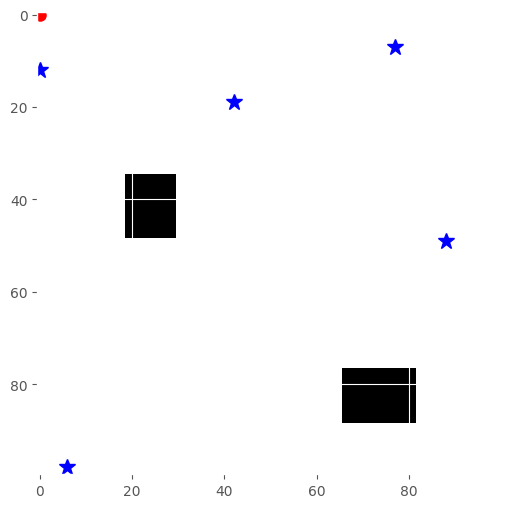

In [ ]:
plot_2d_environment(final_env, radii=radii)

## loss and fitness graphing

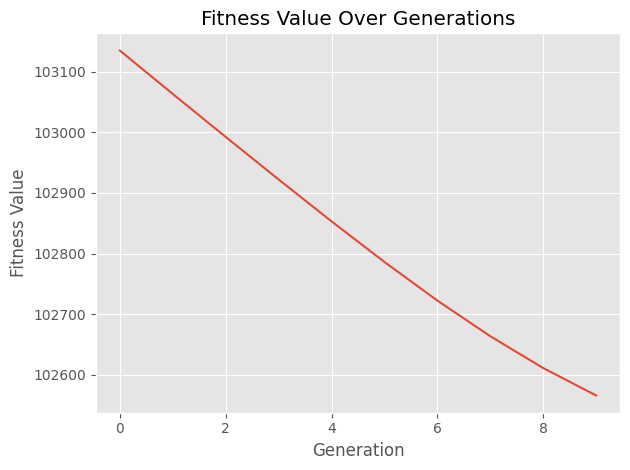

In [ ]:
sns.lineplot(ft_dure_gen)
plt.title("Fitness Value Over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
handles, labels = plt.gca().get_legend_handles_labels()
if handles:
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()